# This notebook allows us to see what output SynthMorph gives us if we give it a pair of sinograms as input

## 1. Import of all the libraries and packages needed to run the code

In [84]:
pip install git+https://github.com/adalca/pystrum.git

  Cloning https://github.com/adalca/pystrum.git to /tmp/pip-req-build-qctv8796
  Running command git clone --filter=blob:none --quiet https://github.com/adalca/pystrum.git /tmp/pip-req-build-qctv8796
  Resolved https://github.com/adalca/pystrum.git to commit 6422922af2607bf740a78526c6be83c388b25c1c
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [85]:
pip install git+https://github.com/adalca/neurite.git

  Cloning https://github.com/adalca/neurite.git to /tmp/pip-req-build-4dg7_mbl
  Running command git clone --filter=blob:none --quiet https://github.com/adalca/neurite.git /tmp/pip-req-build-4dg7_mbl
  Resolved https://github.com/adalca/neurite.git to commit 4d9fbee25a821be477b4c169e528b02be7d76823
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [86]:
pip install git+https://github.com/voxelmorph/voxelmorph.git

  Cloning https://github.com/voxelmorph/voxelmorph.git to /tmp/pip-req-build-vl2yv96d
  Running command git clone --filter=blob:none --quiet https://github.com/voxelmorph/voxelmorph.git /tmp/pip-req-build-vl2yv96d
  Resolved https://github.com/voxelmorph/voxelmorph.git to commit 9fa9cd7631741a73a374d22d6a62ef63afdd23b4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [61]:
import numpy as np
import odl
import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm

## 2. Construction of the foreward projection operation : the ray transform

In [106]:
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[256, 256],
    dtype='float32')
angle_partition = odl.discr.partition.RectPartition(intv_prod=odl.set.domain.IntervalProd(0, 2 * np.pi), grid=odl.discr.grid.RectGrid(np.linspace(0,2*np.pi,360)))
# Detector: uniformly sampled, n = 512, min = -60, max = 60
detector_partition = odl.discr.partition.RectPartition(intv_prod=odl.set.domain.IntervalProd(-60, 60), grid=odl.discr.grid.RectGrid(np.linspace(-60, 60, 512)))
# Geometry with large fan angle
geometry = odl.tomo.geometry.conebeam.FanFlatGeometry(
    apart=angle_partition, dpart=detector_partition, src_radius=40, det_radius=40)
# Ray transform (= forward projection).
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

## 3. Creation of one image and its warped version

In [77]:
# Input shapes.
in_shape = (256,) * 2 # Label maps dimensions. Warning : the shape must be consistent with the operator's shape !
num_dim = len(in_shape)
num_label = 16
num_maps_bis = 1

# Shape generation.
label_maps_bis = []
for _ in tqdm.tqdm(range(num_maps_bis)):
    # Draw image and warp.
    im_bis = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp_bis = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    warped_im = vxm.utils.transform(im_bis, warp_bis)
    lab = tf.argmax(im_bis, axis=-1)
    label_maps_bis.append(np.uint8(lab))
    warped_lab = tf.argmax(warped_im, axis=-1)
    label_maps_bis.append(np.uint8(warped_lab))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


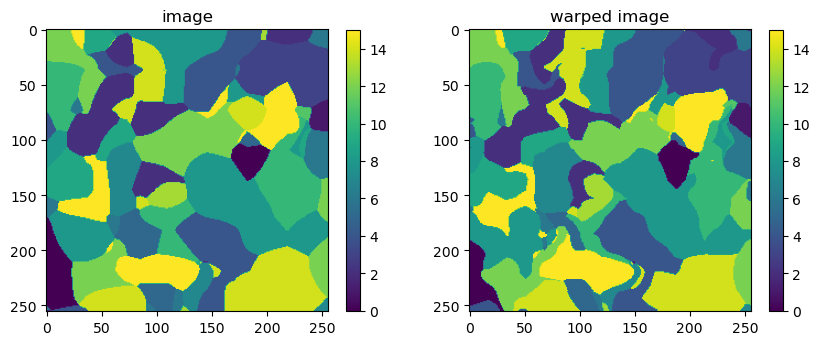

In [78]:
# Visualise the two images.
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(lab[:,:])
plt.title("image")
plt.colorbar(shrink = 0.52)

fig.add_subplot(rows, columns, 2)
plt.imshow(warped_lab[:,:])
plt.title("warped image")
plt.colorbar(shrink = 0.52)

## 4. Creation of the sinograms of these two images

In [79]:
sino_image = ray_trafo(lab[:,:])
sino_warped_image = ray_trafo(warped_lab[:,:])

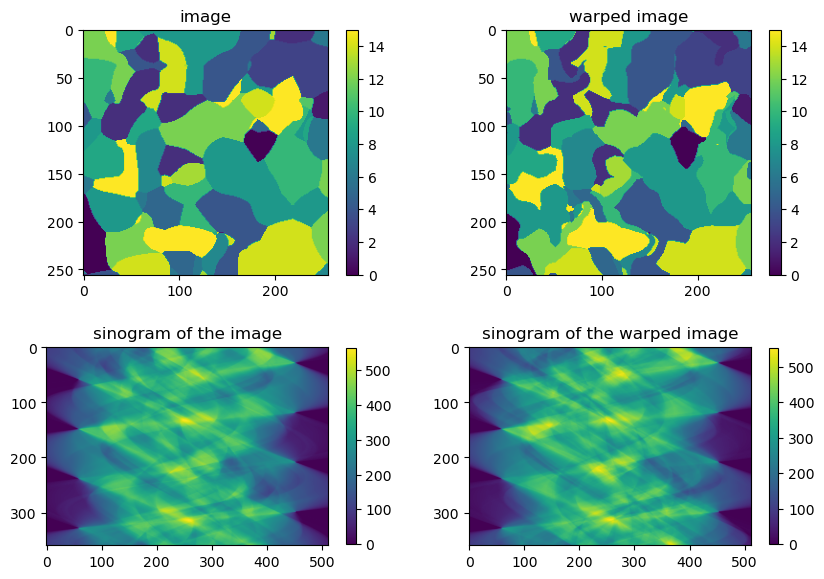

In [82]:
# Visualise the two images and there sinograms.
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(lab[:,:])
plt.title("image")
plt.colorbar()

fig.add_subplot(rows, columns, 2)
plt.imshow(warped_lab[:,:])
plt.title("warped image")
plt.colorbar()

fig.add_subplot(rows, columns, 3)
plt.imshow(sino_image[:,:])
plt.title("sinogram of the image")
plt.colorbar(shrink = 0.8)

fig.add_subplot(rows, columns, 4)
plt.imshow(sino_warped_image[:,:])
plt.title("sinogram of the warped image")
plt.colorbar(shrink = 0.8)

## 5. Recovering SynthMorph trained with 2D label maps

In [68]:
# Input shapes.
in_shape = (256,) * 2 # Label maps dimensions.
num_dim = len(in_shape)
num_label = 16
num_maps = 200 # The number of data pairs we want to train the model with.

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    label_maps.append(np.uint8(lab)) # The label_maps list contains all the data pairs generated above.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


In [69]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape=in_shape,
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)

In [70]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=in_shape,
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([256]*4, [256]*8),
    reg_field='warp',
)


# Model for optimization.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)


# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

100/100 [==============================] - 180s 2s/step - loss: 0.3435


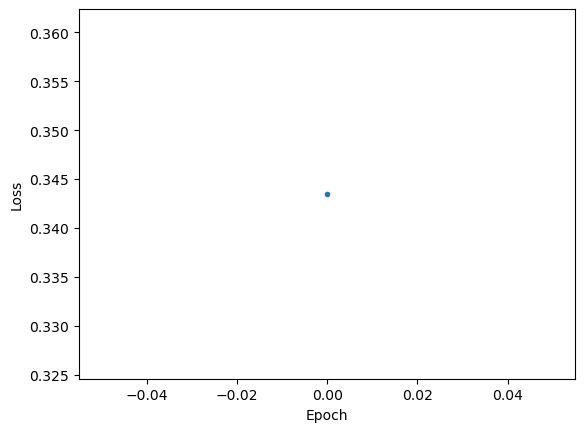

In [71]:
# Train model for a few epochs. 
# Re-running the cell will continue training.
gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1,
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=1,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)


# Visualize loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');

In [72]:
# Download model weights to skip training and save time.
model.load_weights('weights_of_the_U-Net_trained_with_2D_label_maps.h5')

In [73]:
# Conform test data.
def conform(x, in_shape=in_shape):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = np.squeeze(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))

## 6. The output of the model if we put two images as inputs

1/1 [==============================] - 0s 391ms/step


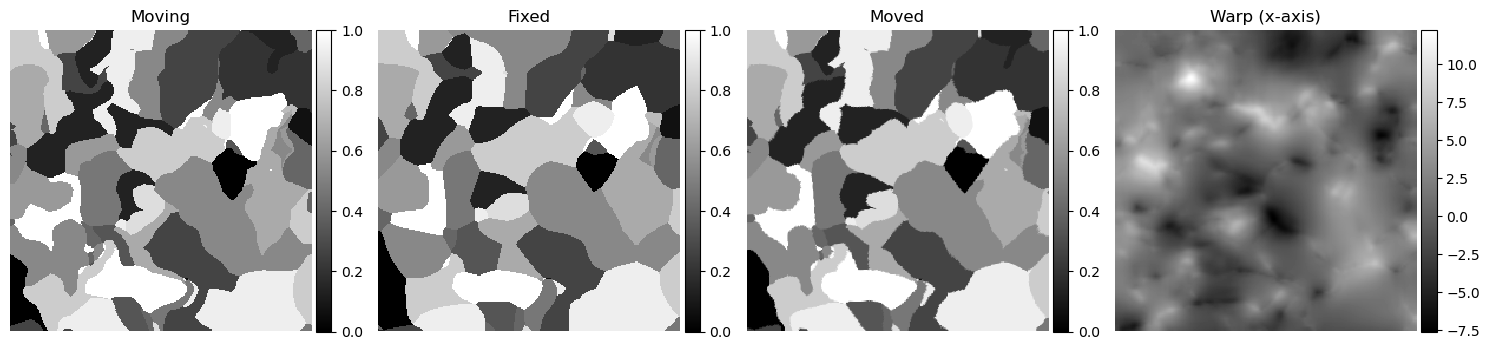

In [83]:
# Test with a random image
moving = conform(warped_lab[:,:])
fixed = conform(lab[:,:])
moved, warp = reg_model.predict((moving, fixed))


ne.plot.slices(
    slices_in=(moving, fixed, moved, warp[..., 0]),
    titles=('Moving', 'Fixed', 'Moved', 'Warp (x-axis)'),
    do_colorbars=True,
);

## 7. The output of the model if we put two sinograms as inputs

1/1 [==============================] - 0s 404ms/step


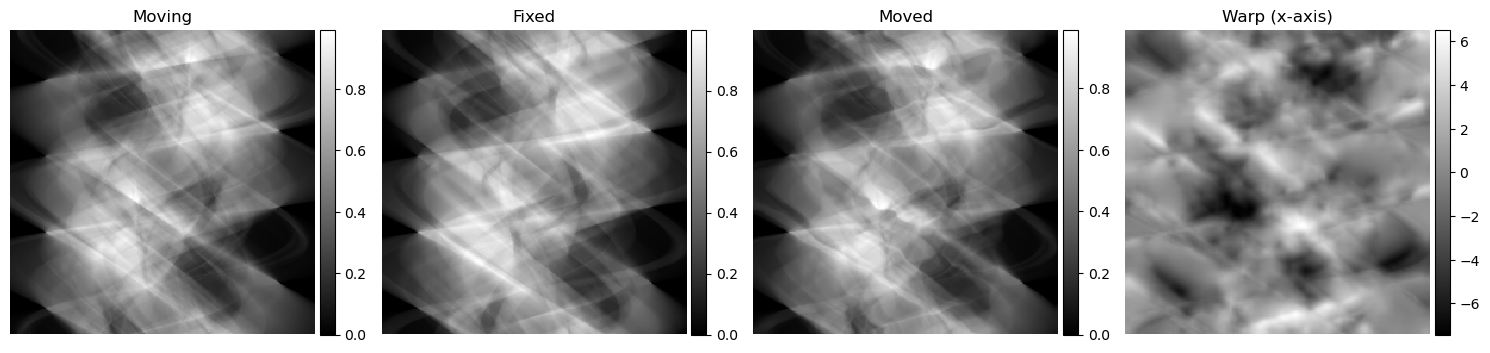

In [104]:
# Test with a random sinogram
moving = conform(proj_warped_image[:,:])
fixed = conform(proj_image[:,:])
moved, warp = reg_model.predict((moving, fixed))



ne.plot.slices(
    slices_in=(moving, fixed, moved, warp[..., 0]),
    titles=('Moving', 'Fixed', 'Moved', 'Warp (x-axis)'),
    do_colorbars=True,
);

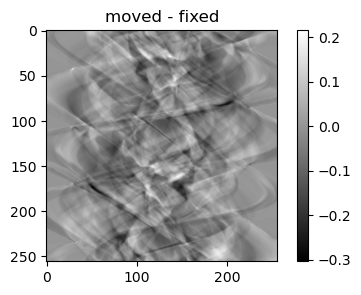

In [105]:
difference = moved - fixed

fig = plt.figure(figsize=(5, 3))
rows = 1
columns = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(difference[0,:,:,0], cmap = 'gray')
plt.title("moved - fixed")
plt.colorbar()

## 8. The output of the model if we put two noisy sinograms as inputs

In [95]:
# Creation of the noisy sinograms.

# After several tests, two breacking points were observed:
# 10^-8 is the limit value where the warp isn't empty. 
# 0.05 the limit value where we can distinguish a sinogram.
noise_level = 0.01 

noisy_sino_image = odl.phantom.noise.poisson_noise(noise_level*sino_image[:,:])/noise_level
noisy_sino_warped_image = odl.phantom.noise.poisson_noise(noise_level*sino_warped_image[:,:])/noise_level

Text(0.5, 1.0, 'noisy warped sinogram with noise_level = 0.1')

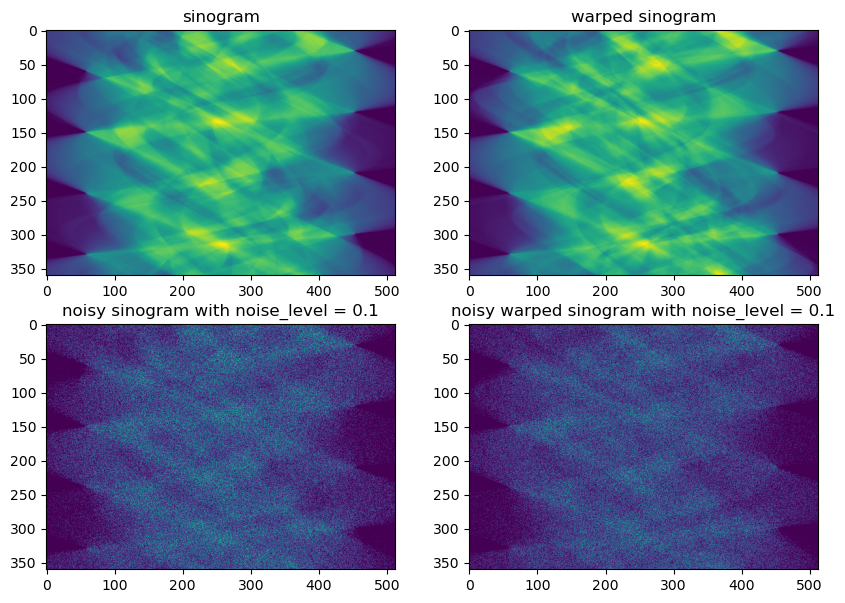

In [96]:
# Visualise sinograms and noisy sinograms.
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(sino_image[:,:])
plt.title("sinogram")

fig.add_subplot(rows, columns, 2)
plt.imshow(sino_warped_image[:,:])
plt.title("warped sinogram")

fig.add_subplot(rows, columns, 3)
plt.imshow(noisy_sino_image[:,:])
plt.title("noisy sinogram with noise_level = 0.1")

fig.add_subplot(rows, columns, 4)
plt.imshow(noisy_sino_warped_image[:,:])
plt.title("noisy warped sinogram with noise_level = 0.1")

1/1 [==============================] - 0s 404ms/step


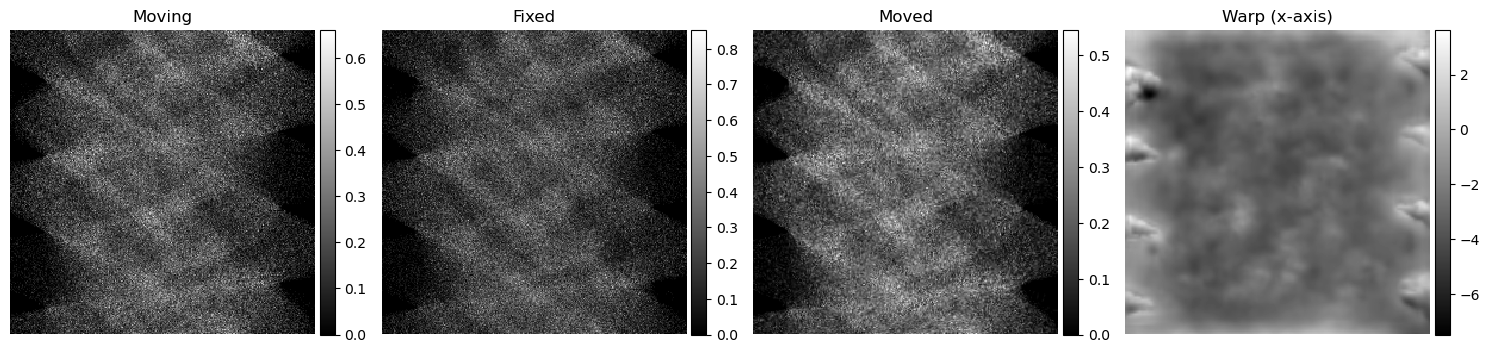

In [98]:
# Test with a noisy random sinogram
moving = conform(noisy_sino_warped_image[:,:])
fixed = conform(noisy_sino_image[:,:])
moved, warp = reg_model.predict((moving, fixed))


ne.plot.slices(
    slices_in=(moving, fixed, moved, warp[..., 0]),
    titles=('Moving', 'Fixed', 'Moved', 'Warp (x-axis)'),
    do_colorbars=True,
);

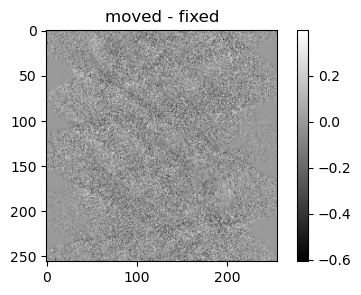

In [103]:
difference = moved - fixed

fig = plt.figure(figsize=(5, 3))
rows = 1
columns = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(difference[0,:,:,0], cmap = 'gray')
plt.title("moved - fixed")
plt.colorbar()